In [2]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

In [4]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [5]:
plt.style.use('../misc/report.mplstyle')
save_dir = "../../../tex/01_regression_resampling/img/"

## Ordinary Least Square on Franke Function

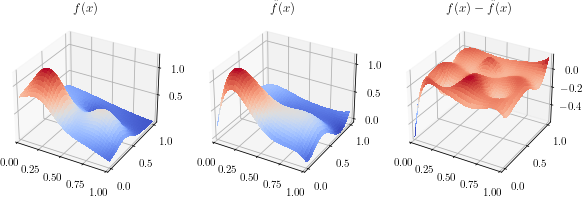

In [9]:
N_uniform = 40
x = np.linspace(0,1,N_uniform)
y = np.linspace(0,1,N_uniform)
X,Y = np.meshgrid(x,y)

kwargs = {"lw":2, 
          "cmap":cm.coolwarm, 
          "antialiased":False}

fig = plt.figure(figsize=(10,24))
ax_data = fig.add_subplot(131, projection='3d')
ax_fit = fig.add_subplot(132, projection='3d')
ax_diff = fig.add_subplot(133, projection='3d')

fXY = franke_function(X,Y)
ax_data.plot_surface(X, Y, fXY, **kwargs)
ax_data.set_title(r"$f(x)$")

# forming the cartesian product of x and y coordinates
xy = np.array([X,Y]).T.reshape(-1,2)
X_uniform = generate_design_matrix(xy[:,0], xy[:,1], p)
fit = ols.predict(X_uniform)
fit = fit.reshape(N_uniform,N_uniform).T

ax_fit.plot_surface(X, Y, fit, **kwargs)
ax_fit.set_title(r"$\hat f(x)$")
ax_diff.plot_surface(X, Y, fit-fXY, **kwargs)
ax_diff.set_title(r"$f(x)-\hat f(x)$")

plt.show()

## Model Selection via Bias-Variance Tradeoff

### Bias Variance Tradeoff without Resampling

To select the best possible model parameters $\{p^*\}$given our data, we attempt to find 
$$
\{p^*\} = \underset{\{p\}}{\operatorname{argmin}}Err = \underset{\{p\}}{\operatorname{argmin}}\mathbb{E}_{S,T}[(Y-\hat f(X)^2]
$$
with the expectation taken over **both**  the randomness in the unseen testpoint $(X,Y) \in S$ and the stochasticity in the training data $T$ (and hence in $\hat f$).  Note that in regression problems data points $X$ that form the training data are assumed random but fixed for the training process. Thus the randomness in the training data is due to the gaussian error $\epsilon$ that promototes $y$ to a random variable.

Evaluating this equation requires us to find an *estimator* for the **expected prediction error** $Err$.
A naive, first attempt follows from evaluating the MSE of a particular trained predictor $\hat f$ either on the training data $T$ (training error) or of the test data $S$ (test error). In  doing so, we obtain a plot simillar to Figure 2.11 of Hastie et. al.

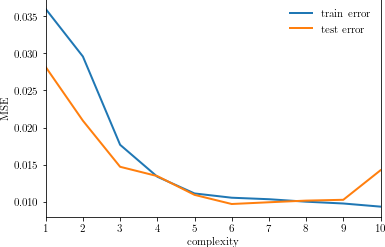

In [27]:
# Data generation
N = 600
x,y,z = random_x_y_franke(N)
complexity = np.arange(1,11)
mse_train = []
mse_test = []

ols = Pipeline([Standardization(), OrdinaryLeastSquare()])

for p in complexity:
    X = generate_design_matrix(x, y, p)
    # Note: we disable shuffling as we want to fit different models to the same training data
    X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.25,shuffle=False)
       
    ols.fit(X_train,y_train)
    
    mse_test.append(mse(y_test, ols.predict(X_test)))
    mse_train.append(mse(y_train, ols.predict(X_train)))
    
fig, ax = plt.subplots()
ax.plot(complexity, mse_train, label="train error")
ax.plot(complexity, mse_test, label="test error")
ax.set(xlabel="complexity", ylabel="MSE")
ax.legend(*ax.get_legend_handles_labels())
ax.set_xlim([complexity[0],complexity[-1]])
plt.show()

Doing so shows a crucial difference: While the training error is (approximately) a decaying function of the  model complexity, the test error increases after the model reaches a certain flexibility. This is known as overfitting and is the result of an highly adaptive (highly variable) model that tends to learn the noise of the training data  rather than the underlying funcitonal relation $f(X)$. The training error does not suffer from the same behavior as it is computed from the data that was used to compute the model (as oppose to unseen data points) in the first place.

A crucial problem of both test/train error is that they do not take into account the randomness of the training set  (no averaging over different predictor realizations is done). Moreover, we already saw that the training error is a highly biased (in the MSE estimator sense) estimtor as it is insensitive to overfitting scenarios  in which it  underestimtates the true expected prediction error significantly.

Resampling methods such as bootstrapping and cross validation address both shortcomings.

### Bootstrapping

Here we estimate the **expected prediction error** $Err$ via bootstrapping, i.e. approximating the distribubtion of $Err$ by generating "new" training sets $T_i$ out of the original set $T$ via a "draw with replacement" strategy. The arithmetic mean of all $Err_i$ (evaluated on test set S) yields an estimator to $Err$ which takes the randomness of the predictor into account.  

In [28]:
# Model parameters
degrees = np.arange(1,11)

# Data parameters
Ns = np.union1d(np.logspace(2,4,200).astype(int), np.arange(100,1000,100))

# Resampling
B = 50

# Predictor Pipeline
ols = Pipeline([Standardization(), OrdinaryLeastSquare()])

prediction_error_bs = np.empty((degrees.shape[0], Ns.shape[0]))
bias = np.empty((degrees.shape[0], Ns.shape[0]))
variance = np.empty((degrees.shape[0], Ns.shape[0]))

for j,N in enumerate(Ns):
    x,y,z = random_x_y_franke(N)
    for k,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        # We disable shuffling as we want to fit different models to the same trainings data. 
        # Note that random resampling (draw + replace) still takes place
        prediction_error_bs[k,j], bias[k,j], variance[k,j] = \
                predicition_error_bootstrap(squared_error, ols, X, z, B=B, decomp=True, shuffle=False)

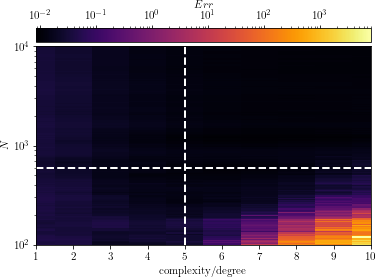

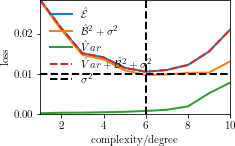

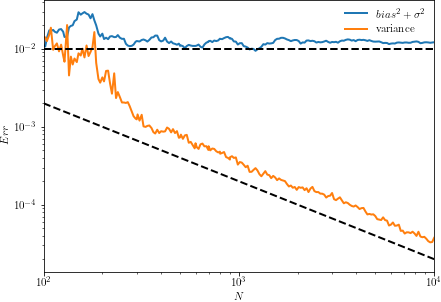

In [29]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

save = False
kwargs = {"lw":2, 
          "cmap":cm.inferno,
          "shading":"nearest",
          "norm":colors.LogNorm(vmin=prediction_error_bs[1:,:].min(), 
                                vmax=prediction_error_bs[1:,:].max()),
          "antialiased":False}

N_cross_section = 600
p_cross_section = 5
idx = np.where(degrees == p_cross_section)[0][0]
idy = np.abs(Ns - N_cross_section).argmin()

fig,ax = plt.subplots()
ax.set_yscale("log")
im = ax.pcolormesh(degrees, Ns, prediction_error_bs.T, **kwargs)
ax.set_xlabel(r'complexity/degree')
ax.set_ylabel(r'$N$')

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(r"$Err$")
cax.xaxis.set_label_position('top') 
ax.axhline(y=N_cross_section, c="w", ls="dashed")
ax.axvline(x=p_cross_section, c="w", ls="dashed")
ax.set_xlim([1,degrees[-1]])
plt.show()

fig, ax = plt.subplots(figsize=set_size("single"))

sigma = 0.1

ax.plot(degrees, prediction_error_bs[:,idy], label=r"$\hat \mathcal{E}$")
ax.plot(degrees, bias[:,idy], label=r"${\hat \mathcal{B}}^2 + \sigma^2$")
ax.plot(degrees, variance[:,idy], label=r"$\hat Var$")
ax.plot(degrees, variance[:,idy] + bias[:,idy], label=r"$\hat Var + {\hat \mathcal{B}}^2 + \sigma^2$", ls="dashed")
ax.set(xlabel="complexity/degree", ylabel=r"loss")
ax.axhline(sigma**2, ls="dashed",c="k", label=r"$\sigma^2$")
ax.axvline(degrees[np.argmin(prediction_error_bs[:,idy])], ls="dashed",c="k")
ax.set_xlim([degrees[0],degrees[-1]])
ax.set_ylim([0,np.max(prediction_error_bs[:,idy])])
ax.legend(*ax.get_legend_handles_labels())

if save:
    fig.savefig(save_dir + "test.pdf")


fig, ax = plt.subplots(figsize=(7,5))
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(Ns, bias[idx,:], label=r"$bias^2 + \sigma^2$")
ax.plot(Ns, variance[idx,:], label=r"variance")
ax.plot(Ns, 1.0/(5*Ns), ls="dashed", c="k")
ax.set(xlabel=r"$N$", ylabel=r"$\hat Err$")
ax.axhline(sigma**2, ls="dashed",color="k")
ax.legend(*ax.get_legend_handles_labels())

We analyze the behavior of $Err$ as function of both the model complexity $p$ (polynomial degree) and the total dataset size $N$. The first plot provides a sweep through this two dimensional parameter space. Figure 2 and 3 illustrate crossection at fixed N or fixed polynomial order.

For **fixed dataset size** ($N=600$), one recovers a error behavior that is qualitatively similar to what the single predictor test error reported, i.e underfitting at low $p$ and overfitting at high $p$. Decomposing $Err$ into:
$$
Err = \sigma^2 + \mathbb{E}[(f-\mathbb{E}[\hat f])^2] + \mathbb{E}[Var[\hat f]] 
= \mathbb{E}[(y-\mathbb{E}[\tilde y])^2] + \mathbb{E}[Var[\tilde y]]
$$
with $\tilde y = \hat f(x)$ yields further insight. We note that the outer expection value averages over all (potentially random) test sights X. The standard bias-variance decomposition is established for a fixed test point $x_0$ and thus only takes the stochasticity of $y_{test}$ (due to $\epsilon$) and $y_{train}$ (due to $\epsilon$) in account. Recall that $X_{train}$ is considered temporally fixed for regression.

The following observations can be made:

1. In theory, the expected prediction error is bounded from below by the irreducable uncertainty $\sigma^2$, originating from the randomness of the test data (i.e. in $y$). If we measure the variance of $\tilde y$ instead of $\hat f$ (as done above) then $\sigma^2$ is absorbed into the bias term, i.e $\mathbb{E}[(y-\mathbb{E}[\tilde y])^2] = \mathbb{E}[(f-\mathbb{E}[\hat f])^2] + \sigma^2$. Comparing with Figure 2, reveals that this is lower bound is approximately satisfied. $p=8$ poses an exception. The reason for this is that we approxinate expectation values with aritmetic means. According to the law of large numbers, both only coincide in the limit $N\to\infty$. Compare also wite the decreasing fluctuation in the bias term as a function of $N$ in Figure 3.

2. Underfitting is driven by the bias term $\mathbb{E}[(f-\mathbb{E}[\hat f])^2]$, which tends to be large if the model is to stiff/inflexible to adapt to the provided training data. The result are predictor realization with prediciton variance but large offset from the true data generating process $f(X)$.

3. At high $p$ the variance term $\mathbb{E}[Var[\tilde y]]  = \mathbb{E}[\mathbb{E}[\tilde y-\mathbb{E}[\tilde y]]]$ dominates as the high flexibility of the polynomial model allows the predictor to better adapt to the inherent noise of the underlying training set. Each predictor realization is therefore highlly dependent on the intrinsic structure of the underlying training set and predictions for **unseen** points will varry widely. 

4. Note that the addtion of each error component recovers the total prediciton error exactly, which we interpret as numerical sanity check that the above decomposition is in fact correct

5. Realize that the training error $\bar err$ behaves roughly as the predictor bias. Thus, together with $Err$, we have sufficient information to make an educated guess about the biasdnesss/variability of the predictor without computing both quantities: High $\bar err$ implies large bias; Large $|\bar err - Err|$ implies significant variance.

For **fixed complexity** ($p=4$) it is possible to analyze to what extend each error contribution depends on the total dataset size $N$. We find:

1. The bias shows no $N$ dependency. This is expected: A simplistic model will not get better if exposed to more data.

2. The variance term decays $\propto 1/N$. This can be explained by computing $Var[\hat f]$

$$
Var[\hat f(x_0)] 
= \dots 
= x_0^T Var(\hat\beta)x_0 
= \dots 
= x_0^T \sigma^2 (X^TX)^{-1}x_0
= \frac{\sigma^2}{N-1} x_0^T  \hat Cov(X)^{-1} x_0 \sim \frac{1}{N} \quad  (N\to\infty)
$$

### Cross-Validation

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Model parameters
degrees = np.arange(1, 11)

# Data generation
N = 600
x,y,z = random_x_y_franke(N)

# Cross validation parameters
Nfolds = np.arange(5,11)

# Predictor Pipeline
ols = OrdinaryLeastSquare()
ols_sk = make_pipeline(StandardScaler(), LinearRegression())

prediction_error_kfold =  np.empty((Nfolds.shape[0], degrees.shape[0]))
prediction_error_kfold_sk =  np.empty((Nfolds.shape[0], degrees.shape[0]))

prediction_error_kfold_std =  np.empty((Nfolds.shape[0], degrees.shape[0]))
prediction_error_kfold_sk_std =  np.empty((Nfolds.shape[0], degrees.shape[0]))

for k,folds in enumerate(Nfolds):
    for i,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        prediction_error_kfold[k,i], prediction_error_kfold_std[k,i] = \
            prediction_error_CV(squared_error, ols, X, z, nfolds=folds)
        scores = cross_val_score(ols_sk, X, y=z, scoring="neg_mean_squared_error", cv=folds)
        prediction_error_kfold_sk[k,i], prediction_error_kfold_sk_std[k,i] = -1.0*np.mean(scores), np.std(scores)

test


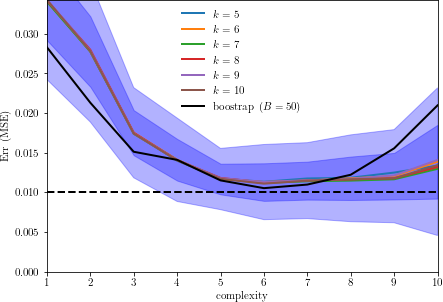

In [31]:
fig, ax = plt.subplots(figsize=(7,5))
set_color_cycle(mpl, "Reds_d", 6)
for k in range(Nfolds.shape[0]):
    ax.plot(degrees, prediction_error_kfold[k,:], label=rf"$k={Nfolds[k]}$")
#ax.plot(degrees, prediction_error_kfold[k,:], label=rf"$k={Nfolds[k]}$")
#ax.plot(degrees, prediction_error_kfold_sk[k,:], label=rf"$k={Nfolds[k]}$")
ax.plot(degrees, prediction_error_bs[:,idy],  c="k", label=r"boostrap $(B=50)$")

ax.fill_between(degrees, 
                prediction_error_kfold[1,:]-prediction_error_kfold_std[1,:], 
               prediction_error_kfold[1,:]+prediction_error_kfold_std[1,:], alpha = 0.3, color="blue")
ax.fill_between(degrees, 
                prediction_error_kfold[1,:]-2*prediction_error_kfold_std[1,:], 
               prediction_error_kfold[1,:]+2*prediction_error_kfold_std[1,:], alpha = 0.3, color="blue")

sigma = 0.1
ax.axhline(y=sigma**2, c="k", ls="dashed")
ax.set(xlabel="complexity", ylabel=r"Err (MSE)")
ax.set_xlim([degrees[0],degrees[-1]])
ax.set_ylim([0,np.max(prediction_error_kfold)])
ax.legend(*ax.get_legend_handles_labels())
plt.show()

## Stochastic Gradient Adaptive Learning Rates

In [91]:
def adagrad():
    # initial learning rate
    eta0 = 1e-2
    # safe-guard against divergence
    epsilon = 1e-8
    g2_t = 0
    while True:
        gradient = yield
        g2_t += gradient**2
        yield eta0 / np.sqrt(epsilon + g2_t)
    
def rmsprop():
    # initial learning rate
    eta0 = 1e-3
    # decay constant
    beta=0.9 
    # safe-guard against divergence
    epsilon = 1e-8
    # moving average of second moment of gradient
    g2_t_avg = 0
    
    while True:
        gradient = yield
        g2_t_avg = beta*g2_t_avg + (1-beta)*gradient**2
        yield eta0 / np.sqrt(epsilon + g2_t_avg)
        
def adam():
    # initial learning rate
    eta0 = 1e-3
    # decay constant for first moment
    beta1=0.9 
    # decay constant for second moment 
    beta2=0.999
    # safe-guard against divergence
    epsilon = 1e-8
    # moving average of second moment of gradient
    g2_t_avg = 0
    # moving average of first moment of gradient
    g_t_avg = 0
    
    while True:
        gradient = yield
        g_t_avg = beta1*g_t_avg + (1-beta1)*gradient
        g2_t_avg = beta2*g2_t_avg + (1-beta2)*gradient**2
        
        g_t_avg_corr = g_t_avg/(1-beta1**2)
        g2_t_avg_corr = g2_t_avg/(1-beta2**2)
        # divide out gradient to conform with structure of standard SGD update (see SVD class defintion)
        yield eta0 / (epsilon + np.sqrt(g2_t_avg_corr) + gradient) * g_t_avg

In [97]:
X = np.c_[np.ones((m,1)), x]
X_scaled = np.c_[np.ones((m,1)), x_scaled]
sgd_own = StochasticGradientDescent(batches=5, 
                                    verbose=True, 
                                    tol=1e-4, 
                                    momentum=0.6,
                                    early_stopping=True, 
                                    validation_fraction=0.2)
sgd_own.fit(X,y.ravel())
print(sgd_own.params)
print(sgd_own.score(X,y.ravel()))

Epoch 0/1000	 Score: 0.7370612300749024	 dScore: 0.6913343205339156
Epoch 1/1000	 Score: 0.75286186355466	 dScore: 0.7070349540136732
Epoch 2/1000	 Score: 0.7815980748852995	 dScore: 0.7356711653443128
Epoch 3/1000	 Score: 0.7793876360927218	 dScore: 0.733360726551735
Epoch 4/1000	 Score: 0.780951261336005	 dScore: 0.04389003126110258
Epoch 5/1000	 Score: 0.7806005734365484	 dScore: 0.027738709881888424
Epoch 6/1000	 Score: 0.7796643218910024	 dScore: -0.0019337529942971
[4.02661268 3.08369202]
0.7657084887427328


In [10]:
from sklearn.model_selection import KFold

nfolds = 5
def split(X,nfolds):
    N = X.shape[0]
    idx = np.arange(N)
    folds = np.array_split(idx, nfolds)
    for i in range(nfolds):
        yield np.sort(np.hstack(folds[1:])), folds[0]
        folds.append(folds.pop(0))

kf =KFold(n_splits=nfolds)

X = np.random.default_rng().integers(100,size=(50,2))
for (train_index, test_index),(train_index_2, test_index_2) in zip(kf.split(X),split(X,nfolds)):
    print(train_index == train_index_2)
    print()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

[ True  True  Tr

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

# Generate the data.
nsamples = 100
x = np.random.randn(nsamples)
y = 3*x**2 + np.random.randn(nsamples)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 6)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((1, k))

ridge = Ridge(alpha = lambdas[10])
j = 0
for train_inds, test_inds in kfold.split(x):
    xtrain = x[train_inds]
    ytrain = y[train_inds]

    xtest = x[test_inds]
    ytest = y[test_inds]

    Xtrain = poly.fit_transform(xtrain[:, np.newaxis])
    ridge.fit(Xtrain, ytrain[:, np.newaxis])

    Xtest = poly.fit_transform(xtest[:, np.newaxis])
    ypred = ridge.predict(Xtest)

    scores_KFold[0,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

    j += 1

print(np.mean(scores_KFold, axis=1))
X = poly.fit_transform(x[:, np.newaxis])
print(prediction_error_CV(squared_error, ridge, X, y[:, np.newaxis], nfolds=k))

[1.08211657]
(1.0821165729699316, 0.3785544328638653)


In [84]:
y_test = np.array([1,2,3,4])
y_test2 = np.array([5,6,7,8])
y_pred = np.c_[(y_test,-y_test)]
y_test = y_test

#print((y_test - y_pred) ** 2)
print(squared_error(y_test[:,np.newaxis],y_pred))

[  0 120]


In [80]:
print(y_test)
print(y_pred)
print(squared_error(1, 2))
print(squared_error(y_test, y_pred))

[1 2 3 4]
[[ 1 -1]
 [ 2 -2]
 [ 3 -3]
 [ 4 -4]]
1
[  0 120]


In [121]:
import matplotlib as mpl
cmap = mpl.colormaps['viridis']

AttributeError: module 'matplotlib' has no attribute 'colormaps'

In [141]:
from matplotlib.colors import ListedColormap
test = sns.color_palette("inferno", as_cmap=True)
test([0,1])

array([[1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00],
       [2.2670e-03, 1.2700e-03, 1.8570e-02, 1.0000e+00]])

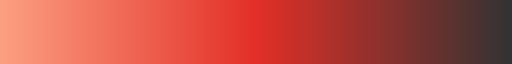

In [144]:
sns.color_palette("Reds_d", as_cmap=True)
